#  <span style="color: #4daafc">Legal Case Similarity Detection - Baseline Results</span>

- [Environment](#environment)
- [Load data](#load-data)
- [Hybrid search](#hybrid-search)
  - [Hybrid search function](#hybrid-search-function)
  - [Hybrid search evaluation](#hybrid-search-evaluation)
- [Helper functions](#helper-functions)
- [Evaluation](#evaluation)
  - [Evaluation metric recall@3](#evaluation-metric-recall3)
  - [Evaluation metric precision@k](#evaluation-metric-precisionk)

# Environment

### Prepare python environment

In [1]:
import numpy as np
from utils.embedding import get_embedding_handler
from utils.db import load_vector_db
from utils.str_utils import str_to_arr
from langchain.schema import Document
from sklearn.metrics.pairwise import pairwise_distances
from typing import Dict
from utils.file_utils import load_file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from ast import literal_eval
from typing import Callable, Tuple, Dict, List, Union
from itertools import product

# ignore warnings
import warnings
from sklearn.exceptions import DataConversionWarning

In [2]:
# ignore specific warning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Global variables

In [3]:
base_url = "http://localhost:11434"
emb_model = 'nomic-embed-text:latest'

# Load data

### Load dense vector DB (FAISS)

In [4]:
db_name = "db/vectors/db_legal_cases_summary_100"
embedding_handler = get_embedding_handler(model=emb_model, base_url=base_url)
vector_store = load_vector_db(db_name, embedding_handler, trust_source=True)
retriever = vector_store.as_retriever(search_type = 'similarity', search_kwargs = {'k': 3})

load_vector_db: successfully loaded vector db from db/vectors/db_legal_cases_summary_100


In [5]:
docstore_id_to_indx = {value: key for key, value in vector_store.index_to_docstore_id.items()}
list(docstore_id_to_indx.items())[:10] # display first n elements

[('e4b649c3-1e33-47e2-a9da-3785d1b98105', 0),
 ('5c409d5e-9449-4af6-84f8-676cf1150094', 1),
 ('884a094b-0e06-49b2-b976-b70692aa5a97', 2),
 ('d9787e86-b812-4256-ab32-e8c1f6735e48', 3),
 ('691ee6a2-c4be-470c-9e17-a0b79cf213d2', 4),
 ('af0dfd09-d4fd-400a-8f59-1677d34c98f3', 5),
 ('3591af72-0202-4f09-bd76-338ab6aa8b81', 6),
 ('b0efc033-aeda-4db2-b5f2-a865869dd280', 7),
 ('0ac4dbe2-508d-47e3-8212-502b514aa060', 8),
 ('27a82aa3-4369-4577-8f3c-08e4c87a4c90', 9)]

### Load sparse vectors (One-hot)

In [6]:
f_path_sparse_vec = "db/vectors/sparse_vectors.npy"
sparse_vectors = np.load(f_path_sparse_vec)

### Load human-evaluated data

In [7]:
ref_f_name = 'data/lcsd_ref_results.xlsx'
df_ref = load_file(ref_f_name)

Successfully loaded DataFrame from data/lcsd_ref_results.xlsx


In [8]:
# convert result column from str to python list
df_ref["result"] = df_ref["result"].apply(literal_eval)

# Create a dictionary: (case_number, tool) -> [list of similar case_numbers]
reference_map = {
    (row["case_number"], row["tool"]): row["result"]
    for _, row in df_ref.iterrows()
}

reference_map

{('1494/07', 'human'): ['4882/06', '7092/03', '8970/15'],
 ('1494/07', 'ChatGPT 4o'): ['4882/06', '8970/15', '319/21'],
 ('9376/00', 'human'): ['1385/01', '4477/00', '6386/00'],
 ('9376/00', 'ChatGPT 4o'): ['4477/00', '1385/01', '6386/00'],
 ('5668/13', 'human'): ['7817/18', '6423/11', '2542/19'],
 ('5668/13', 'ChatGPT 4o'): ['4446/20', '6423/11', '7176/04'],
 ('3015/09', 'human'): ['6068/21', '8750/16', '4182/10'],
 ('3015/09', 'ChatGPT 4o'): ['8750/16', '6068/21', '4882/06'],
 ('6746/98', 'human'): ['319/21', '7516/12', '4182/10'],
 ('6746/98', 'ChatGPT 4o'): ['7516/12', '4182/10', '319/21']}

# Hybrid Search

### Hybrid search function 
$$
\text{Hybrid score} = \alpha \cdot \text{Dense score} + (1 - \alpha) \cdot \left(\text{Sparse score}\right)^\gamma
$$

Where:
  - $\alpha$: weight parameter αϵ[0,1] - balances the dense vs. sparse contribution
  - $\gamma$: exponent scale-up to adjust the impact of sparse score (since sparse score values can be very low)
  - $\text{Dense score}$ : calculated using cosine similarity
  - $\text{Sparse score}$ : calculated using Jaccard similarity on binary vectors


$$
\text{Jaccard similarity}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

Where: 
  - $A,B$: binary vectors
  - $i$: index in vector
  - $A_i \cap B_i = 1$: intersection of citations (shared citations - same law or precedent)
  - $A_i \cup B_i = 1$: union or total active citations (at least one cites the law or precedent)



In [9]:
def hybrid_search(doc_id: str, alpha: float = 0.5, k: int = 5, sparse_exp: float = 0.5) -> Dict[str, float] | str:
    """
    Find similar documents/legal cases in the database. 

    Args:
        doc_id (str): document identifier (legal case number). Example: 3015/09
        alpha (float): Weighting factor for dense vs sparse search (0.0 = only sparse, 1.0 = only dense).
        k (int): Number of top results to return.
        sparse_exp (float): Power exponent to apply to sparse scores to boost their impact.
            Values < 1 (e.g., 0.5) boost small similarity scores; values > 1 reduce them.

    Returns:
        Dict[str, float]: Mapping of case_number to hybrid similarity score.
    """
    if not doc_id:
        return "Error: 'doc_id' is required as input."

    # check if the document ID exists in the database
    doc: Document = next((d for d in vector_store.docstore._dict.values() if d.metadata.get("case_number") == doc_id), None)
    if not doc:
        return f"Document ID '{doc_id}' not found in the database."
    
    # get the index of the document we're querying
    query_doc_idx = docstore_id_to_indx.get(doc.id)
    
    # get the embedding for the user's document. Normalized dense vector (L2 norm = 1)
    query_dense_vector = embedding_handler.embed_documents([doc.page_content])[0]

    # sparse vector (one-hot encoded)
    query_sparse_vector = str_to_arr(doc.metadata['legal_refs_sparse_vec'])

    # dense search (FAISS)
    dense_results = vector_store.similarity_search_with_score_by_vector(query_dense_vector, k=k+1)

    # extract FAISS document indexes and similarity scores
    dense_scores = {docstore_id_to_indx.get(d.id): score for d, score in dense_results if docstore_id_to_indx.get(d.id) != query_doc_idx}

    # sparse search using Jaccard similarity
    # .reshape(1, -1) converts query_sparse_vector from shape (n,) (1D) to shape (1, n) (2D)
    jaccard_distances = pairwise_distances(query_sparse_vector.reshape(1, -1), sparse_vectors, metric="jaccard")[0]

    # convert distances to similarity (Jaccard similarity = 1 - Jaccard distance)
    sparse_scores = 1 - jaccard_distances

    # since sparse scores have relatively small values comparing to dense vector cosine similarity scores, 
    # decided to scale-up the values using power exponent
    sparse_scores = np.power(sparse_scores, sparse_exp)

    # merge scores using weighted sum
    combined_scores = {}
    for idx in range(sparse_vectors.shape[0]):  # iterate through document indices
        if idx != query_doc_idx:
            dense_score = dense_scores.get(idx, 0)  # FAISS similarity score
            sparse_score = sparse_scores[idx]  # Jaccard similarity score
            combined_scores[idx] = alpha * dense_score + (1 - alpha) * sparse_score
            #print(f"indx={idx}, dense score={float(dense_score)}, sparse_score={float(sparse_score)}, combined score={combined_scores[idx]}")

    # rank documents by combined score
    ranked_docs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    # return top k documents
    res = {vector_store.docstore._dict[vector_store.index_to_docstore_id[d_idx]].metadata['case_number']: float(d_scr) for d_idx, d_scr in ranked_docs[:k]}
    return res

### Hybrid search evaluation

**Recall@3** - how many of the top-3 human ground truth cases found using the hybrid search
$$\text{Recall@}3=\frac{|\text{top-k relevant cases found}|}{k}$$
Example: I have retrieved [a, b, c, d, e], and ground truth [a, d, e]. All 3 appear in ground truth.
$$\text{Recall@}3=\frac{3}{3}=1.0$$

**Precision@k** - proportion of top-k hybrid search retrieved cases that appear in the ground truth set
$$\text{Precision@}k=\frac{|\text{Relevant cases in top-}k|}{k}$$
Example: I have retrieved 5 documents, and 4 of them are relevant.
$$\text{Precision@}5=\frac{4}{5}=0.8$$

In [10]:
def sklearn_precision(retrieved: list, relevant: list, k: int) -> float:
    """
    Computes precision using sklearn's precision_score, assuming all retrieved items are predicted as relevant.

    Args:
        retrieved (list): List of retrieved items (case identifiers).
        relevant (list): List of ground truth relevant items.
        k (int): Number of top items to consider (not directly used here, for consistency).

    Returns:
        float: Precision score.
    """
    y_true = [1 if case in relevant else 0 for case in retrieved]
    y_pred = [1] * len(retrieved)
    return precision_score(y_true, y_pred, zero_division=0)

def sklearn_recall(retrieved: list, relevant: list, k: int) -> float:
    """
    Computes recall using sklearn's `recall_score`, assuming all retrieved items are predicted as relevant.

    Args:
        retrieved (list): List of retrieved items (case identifiers).
        relevant (list): List of ground truth relevant items.
        k (int): Number of top items to consider (not directly used here, for consistency).

    Returns:
        float: Recall score.
    """
    y_true = [1 if case in relevant else 0 for case in retrieved]
    y_pred = [1] * len(retrieved)
    return recall_score(y_true, y_pred, zero_division=0)

def sklearn_f1(retrieved: list, relevant: list, k: int) -> float:
    """
    Computes F1 score using sklearn's `f1_score`, assuming all retrieved items are predicted as relevant.

    Args:
        retrieved (list): List of retrieved items (case identifiers).
        relevant (list): List of ground truth relevant items.
        k (int): Number of top items to consider (not directly used here, for consistency).

    Returns:
        float: F1 score.
    """
    y_true = [1 if case in relevant else 0 for case in retrieved]
    y_pred = [1] * len(retrieved)
    return f1_score(y_true, y_pred, zero_division=0)

def precision_at_k(retrieved: list, relevant: list, k: int) -> float:
    """
    Computes precision@k: proportion of relevant items among the top-k retrieved.

    Args:
        retrieved (list): List of retrieved items (ranked).
        relevant (list): List of ground truth relevant items.
        k (int): Number of top items to consider.

    Returns:
        float: Precision at k.
    """
    retrieved_top_k = retrieved[:k]
    if not retrieved_top_k:
        return 0.0
    num_relevant = sum(1 for item in retrieved_top_k if item in relevant)
    return num_relevant / k

def recall_at_3(retrieved: list, relevant: list, k: int = 3) -> float:
    """
    Computes recall@3: proportion of the top-3 relevant items found in the retrieved list.

    Args:
        retrieved (list): List of retrieved items.
        relevant (list): List of ground truth relevant items (at least 3 expected).
        k (int): Placeholder for API consistency; always uses top-3 relevant items.

    Returns:
        float: Recall at 3.
    """
    num_relevant = sum(1 for item in relevant[:3] if item in retrieved)
    return num_relevant / 3


#  Scoring registry dictionary 
scoring_functions: Dict[str, Callable[[list, list, int], float]] = {
    "precision": sklearn_precision,
    "recall": sklearn_recall,
    "f1": sklearn_f1,
    "precision@k": precision_at_k,
    "recall@3": recall_at_3,
}


#  Hybrid search evaluation function)
def hybrid_search_evaluation(
    hybrid_search_func: Callable,
    scoring: str,
    alpha_values: List[float] = [0.0, 0.3, 0.5, 0.7, 1.0],
    sparse_exp_values: List[float] = [0.1, 0.3, 0.5, 0.7, 1.0],
    k_values: List[int] = [3, 5, 10]
) -> Dict[str, pd.DataFrame]:
    """
    Evaluates a hybrid search function across different parameter combinations and scoring metrics.

    Args:
        hybrid_search_func (Callable): A function that retrieves similar cases for a given input.
        scoring (str): The name of the scoring metric to use (must be in `scoring_functions`).
        alpha_values (List[float]): List of alpha values to test.
        sparse_exp_values (List[float]): List of sparse exponent values to test.
        k_values (List[int]): List of k values (top-k retrieved items to evaluate).

    Returns:
        Dict[str, pd.DataFrame]: A dictionary with:
            - "all_scores": Full DataFrame of all evaluation results.
            - "average_scores": Mean score per (case, tool).
            - "best_per_case_tool": Best configuration for each (case, tool).
            - "best_configurations": Aggregated score per (alpha, sparse_exp, k).
            - "best_overall": Configuration with highest overall average score.
    """
    if scoring not in scoring_functions:
        raise ValueError(f"Unsupported scoring method: {scoring}")

    scorer = scoring_functions[scoring]
    all_results = []

    for alpha, k in product(alpha_values, k_values):
        # Decide which sparse_exp_values to use (skip if alpha == 1.0)
        relevant_sparse_exps = [None] if alpha == 1.0 else sparse_exp_values

        for sparse_exp in relevant_sparse_exps:
            for (case_number, tool), expected_similars in reference_map.items():
                # Set dummy value for sparse_exp if not applicable
                actual_sparse_exp = sparse_exp if sparse_exp is not None else 0.0
                retrieved_dict = hybrid_search_func(case_number, alpha=alpha, k=k, sparse_exp=actual_sparse_exp)
                if isinstance(retrieved_dict, str):
                    continue
                retrieved_cases = list(retrieved_dict.keys())
                score = scorer(retrieved_cases, expected_similars, k)
                all_results.append({
                    "case_number": case_number,
                    "tool": tool,
                    "alpha": alpha,
                    "sparse_exp": actual_sparse_exp if sparse_exp is not None else "N/A",
                    "k": k,
                    "score": score
                })

    df_all = pd.DataFrame(all_results)
    df_avg = df_all.groupby(["case_number", "tool"])["score"].mean().reset_index().rename(columns={"score": "avg_score"})
    best_per_case_tool = df_all.loc[df_all.groupby(["case_number", "tool"])["score"].idxmax()].reset_index(drop=True)
    best_configurations = (
        df_all.groupby(["alpha", "sparse_exp", "k"])["score"]
        .mean()
        .reset_index()
        .rename(columns={"score": "avg_score"})
        .sort_values("avg_score", ascending=False)
    )
    best_overall = best_configurations.head(1)

    return {
        "all_scores": df_all,
        "average_scores": df_avg,
        "best_per_case_tool": best_per_case_tool,
        "best_configurations": best_configurations,
        "best_overall": best_overall
    }

Hybrid (weighted score) search example

In [11]:
res_search = hybrid_search(doc_id='6746/98', alpha=0.5, k=5, sparse_exp=0.1)
res_search

{'967/97': 0.4295951724052429,
 '4182/10': 0.4229828715324402,
 '7516/12': 0.4222625494003296,
 '6423/11': 0.41995614767074585,
 '4890/98': 0.41721415519714355}

# Helper functions

Summarize results per case number and reference evaluation tool (human or ChatGPT 4o)

In [12]:
def summarize_case_tool_scores(df_all: pd.DataFrame) -> pd.DataFrame:
    """
    Create a summary table per (case_number, tool) with average, best, and worst score + configs.

    Args:
        df_all (pd.DataFrame): All raw scores from comprehensive evaluation.

    Returns:
        pd.DataFrame: Summary with avg, best, worst scores and their parameter configs.
    """
    summaries = []

    for (case, tool), group in df_all.groupby(["case_number", "tool"]):
        avg_score = group["score"].mean()

        best_row = group.loc[group["score"].idxmax()]
        worst_row = group.loc[group["score"].idxmin()]

        summaries.append({
            "case_number": case,
            "tool": tool,
            "avg_score": avg_score,
            "best_score": best_row["score"],
            "best_params": (best_row["alpha"], best_row["sparse_exp"], best_row["k"]),
            "worst_score": worst_row["score"],
            "worst_params": (worst_row["alpha"], worst_row["sparse_exp"], worst_row["k"]),
        })

    return pd.DataFrame(summaries)


Summarizes the results per case for top-K values (mean, max, min)

In [13]:
def summarize_results_by_k(
    df_all: pd.DataFrame,
    tool: str = None,
    k: List[int] = [5],
    aggregation: str = "mean"  # options: "mean", "max", "min"
) -> pd.DataFrame:
    """
    Summarizes evaluation scores per test case with columns for top-K values,
    grouped by tool. Includes average row per tool based on provided k values.

    Args:
        df_all (pd.DataFrame): Output from comprehensive_hybrid_search_evaluation()['all_scores']
        tool (str, optional): Filter results for a specific tool (e.g., 'human', 'ChatGPT 4o')
        k (List[int]): List of K values (e.g., [3, 5, 10]) to include in the output.
        aggregation (str): Aggregation method: "mean", "max", or "min"

    Returns:
        pd.DataFrame: Summary with top-K columns and average rows per tool.
    """
    if tool:
        df_all = df_all[df_all["tool"] == tool]

    if aggregation == "mean":
        grouped = df_all.groupby(["tool", "case_number", "k"])["score"].mean()
    elif aggregation == "max":
        grouped = df_all.groupby(["tool", "case_number", "k"])["score"].max()
    elif aggregation == "min":
        grouped = df_all.groupby(["tool", "case_number", "k"])["score"].min()
    else:
        raise ValueError("Invalid aggregation method. Use 'mean', 'max', or 'min'.")

    # Pivot and rename only requested K values
    summary = (
        grouped
        .unstack("k")
        .rename(columns=lambda x: f"top {x}")
        .reset_index()
    )

    # Keep only the requested top-k columns
    top_k_cols = [f"top {k}" for k in k if f"top {k}" in summary.columns]
    summary = summary[["tool", "case_number"] + top_k_cols]

    # Add average row per tool
    extra_rows = []
    for t in summary["tool"].unique():
        sub = summary[summary["tool"] == t]
        row = {col: np.nan for col in summary.columns}
        row.update({"tool": t, "case_number": "average"})
        for col in top_k_cols:
            row[col] = sub[col].mean(skipna=True)
        extra_rows.append(row)

    if extra_rows:
        summary = pd.concat([summary, pd.DataFrame(extra_rows)], ignore_index=True)

    return summary

Summarizes best configuration for each k values

In [14]:
def summarize_best_configurations_by_k(
    df_all: pd.DataFrame,
    aggregation: str = "mean"  # options: "mean", "max", "min"
) -> pd.DataFrame:
    """
    Retrieves the best hybrid search configurations per k value based on a chosen aggregation method.

    Args:
        df_all (pd.DataFrame): Output from hybrid_search_evaluation()["all_scores"].
        aggregation (str): Aggregation method to evaluate configurations ("mean", "max", or "min").

    Returns:
        pd.DataFrame: Best configuration per each k with its average/max/min score.
    """
    if aggregation not in {"mean", "max", "min"}:
        raise ValueError("aggregation must be one of: 'mean', 'max', 'min'")

    agg_func = {"mean": "mean", "max": "max", "min": "min"}[aggregation]

    grouped = (
        df_all.groupby(["alpha", "sparse_exp", "k"])["score"]
        .agg(agg_func)
        .reset_index()
        .rename(columns={"score": f"{aggregation}_score"})
    )

    best_per_k = grouped.loc[grouped.groupby("k")[f"{aggregation}_score"].idxmax()].reset_index(drop=True)

    return best_per_k


def get_best_configurations(
    df_all_scores: pd.DataFrame,
    aggregation: str = "mean"  # Options: "mean", "max", "min"
) -> pd.DataFrame:
    """
    Computes the best hybrid search configurations based on the specified aggregation method.

    Args:
        df_all_scores (pd.DataFrame): The 'all_scores' DataFrame from hybrid_search_evaluation().
        aggregation (str): Aggregation method to use for scoring ("mean", "max", or "min").

    Returns:
        pd.DataFrame: Sorted DataFrame of best configurations grouped by (alpha, sparse_exp, k).
    """
    if aggregation not in {"mean", "max", "min"}:
        raise ValueError("aggregation must be one of: 'mean', 'max', 'min'")

    score_column = f"{aggregation}_score"

    best_configurations = (
        df_all_scores
        .groupby(["alpha", "sparse_exp", "k"])["score"]
        .agg(aggregation)
        .reset_index()
        .rename(columns={"score": score_column})
        .sort_values(score_column, ascending=(aggregation == "min"))
    )

    return best_configurations

Plots a bar chart of scores per case number and tool (human or ChatGPT 4o)

In [15]:
def plot_summary_bar_chart(
    summary_df: pd.DataFrame,
    summary_k: Union[int, List[int]] = 5,
    include_average: bool = True,
    figsize: Tuple[int, int] = (14, 6)
):
    """
    Plots a grouped bar chart of scores per (case_number, tool), with bars for each top-K.
    Legend shows tool name and K value, each combination with a distinct color.

    Args:
        summary_df (pd.DataFrame): Output from summarize_results_by_k function.
        summary_k (int or List[int]): Which 'top K' column(s) to plot (e.g., 3, 5, 10).
        include_average (bool): Whether to include the average row in the plot.
        figsize (Tuple[int, int]): Size of the figure in inches (width, height).
    """
    if isinstance(summary_k, int):
        summary_k = [summary_k]

    columns_to_plot = [f"top {k}" for k in summary_k]

    if not include_average:
        plot_df = summary_df[summary_df["case_number"] != "average"]
    else:
        plot_df = summary_df.copy()

    plot_df["label"] = plot_df["case_number"] + " (" + plot_df["tool"] + ")"
    labels = plot_df["label"].tolist()
    x = np.arange(len(labels))

    tools = plot_df["tool"].unique()
    combinations = [(tool, col) for tool in tools for col in columns_to_plot]
    width = 0.8 / len(combinations)

    plt.figure(figsize=figsize)
    color_map = plt.colormaps.get_cmap("tab20").resampled(len(combinations))

    for idx, (tool, col) in enumerate(combinations):
        heights = []
        for _, row in plot_df.iterrows():
            if row["tool"] == tool:
                heights.append(row[col])
            else:
                heights.append(0)

        offset = (idx - len(combinations) / 2) * width + width / 2
        plt.bar(
            x + offset,
            heights,
            width=width,
            label=f"{tool} - {col}",
            color=color_map(idx)
        )

    plt.xlabel("Case Number (Tool)")
    plt.ylabel("Score")
    plt.title(f"Scores for Top {', '.join(map(str, summary_k))} by Case and Tool")
    plt.xticks(ticks=x, labels=labels, rotation=45, ha="right")
    plt.legend(title="Tool - Top K", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Plot average score vs alpha for each other parameter values

In [16]:
def plot_score_vs_alpha(
    config_df: pd.DataFrame,
    aggregation: str = 'mean',  # Options: 'mean', 'max', 'min'
    metric: str = 'recall@3',  # Options: 'recall@3', 'precision@k'
    figsize: Tuple[int, int] = (12, 6)
) -> None:
    """
    Plots Precision@k vs Alpha for different sparse_exp and k using pre-aggregated config DataFrame.

    Args:
        config_df (pd.DataFrame): Output from get_best_configurations().
        aggregation (str): Aggregation method used ("mean", "max", "min") to select score column.
        metric (str): metric that was used either recall@3 or precision@k
        figsize (Tuple[int, int]): Size of the figure in inches (width, height).
    """
    if aggregation not in {"mean", "max", "min"}:
        raise ValueError("aggregation must be one of: 'mean', 'max', 'min'")

    score_column = f"{aggregation}_score"
    df_plot = config_df.copy()
    df_plot['sparse_exp'] = df_plot['sparse_exp'].astype(str)

    # Plot
    plt.figure(figsize=figsize)
    sns.lineplot(
        data=df_plot,
        x="alpha",
        y=score_column,
        hue="sparse_exp",
        style="k",
        markers=True,
        dashes=False
    )

    plt.title(f"{metric} vs alpha for different sparse_exp and k")
    plt.xlabel("alpha (dense-sparse weight)")
    plt.ylabel(f"{aggregation.capitalize()} {metric}")
    plt.legend(title="sparse exp / k", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Plot a heatmap by alpha and k value

In [17]:
def plot_alpha_sparse_heatmap(
    best_configurations: pd.DataFrame,
    k: int = 5,
    score: str = "mean"  # options: "mean", "max", "min"
):
    """
    Heatmap of score by alpha and sparse_exp for a given k.

    Args:
        best_configurations (pd.DataFrame): DataFrame from 'best_configurations' key in evaluation output.
        k (int): K value to filter by before plotting.
    """

    df = best_configurations[best_configurations["k"] == k]
    heatmap_data = df.pivot(index="sparse_exp", columns="alpha", values=f"{score}_score")

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f"Heatmap of {score} score (k={k})")
    plt.xlabel("Alpha (Dense Weight)")
    plt.ylabel("Sparse Exp")
    plt.tight_layout()
    plt.show()

Plots score vs k value

In [18]:
def plot_score_per_k( 
    config_df: pd.DataFrame,
    aggregation: str = "mean",  # Options: 'mean', 'max', 'min'
    metric: str = 'recall@3',  # For plot title only: 'precision@k' or 'recall@3'
    figsize: Tuple[int, int] = (6, 5)
) -> None:
    """
    Plots a bar chart of the best configuration's score for each k value.

    Args:
        config_df (pd.DataFrame): Output from get_best_configurations().
        aggregation (str): Aggregation method used ("mean", "max", or "min") to select the score column.
        metric (str): 'precision@k' or 'recall@3' for labeling purposes.
        figsize (Tuple[int, int]): Size of the figure in inches (width, height).
    """
    if aggregation not in {"mean", "max", "min"}:
        raise ValueError("aggregation must be one of: 'mean', 'max', 'min'")

    score_column = f"{aggregation}_score"

    # Prepare and filter data
    df_plot = config_df.copy()
    df_plot["sparse_exp"] = df_plot["sparse_exp"].astype(str)

    # Select best score per k
    best_per_k = df_plot.loc[df_plot.groupby("k")[score_column].idxmax()].reset_index(drop=True)

    # Plot
    plt.figure(figsize=(figsize))
    sns.barplot(
        data=best_per_k,
        x="k",
        y=score_column,
        hue="sparse_exp"
    )

    plt.title(f"{aggregation.capitalize()} {metric} Score per k")
    plt.xlabel("Top-k Value")
    plt.ylabel(f"{aggregation.capitalize()} {metric}")
    plt.legend(title="Sparse Exp")
    plt.tight_layout()
    plt.show()

# Evaluation

## Evaluation metric recall@3

In [19]:
eval_res_recall_3 = hybrid_search_evaluation(hybrid_search_func=hybrid_search, scoring='recall@3', alpha_values=[1.0, 0.7, 0.5, 0.3, 0.0], sparse_exp_values=[1.0, 0.5, 0.01], k_values = [3, 5, 10])

In [20]:
pd.set_option('display.max_rows', eval_res_recall_3["all_scores"].shape[0])
eval_res_recall_3["all_scores"]

,case_number,tool,alpha,sparse_exp,k,score
0,1494/07,human,1.0,N/A,3,1.000000
1,1494/07,ChatGPT 4o,1.0,N/A,3,0.666667
2,9376/00,human,1.0,N/A,3,0.666667
3,9376/00,ChatGPT 4o,1.0,N/A,3,0.666667
4,5668/13,human,1.0,N/A,3,0.666667
5,5668/13,ChatGPT 4o,1.0,N/A,3,0.333333
6,3015/09,human,1.0,N/A,3,0.666667
7,3015/09,ChatGPT 4o,1.0,N/A,3,0.333333
8,6746/98,human,1.0,N/A,3,0.666667
9,6746/98,ChatGPT 4o,1.0,N/A,3,0.666667


### recall@3 for top 3,5,10 - average results

In [21]:
summarize_results_by_k(eval_res_recall_3['all_scores'], k=[3, 5, 10])

,tool,case_number,top 3,top 5,top 10
0,ChatGPT 4o,1494/07,0.538462,0.589744,0.589744
1,ChatGPT 4o,3015/09,0.333333,0.461538,0.461538
2,ChatGPT 4o,5668/13,0.256410,0.333333,0.589744
3,ChatGPT 4o,6746/98,0.512821,0.512821,0.512821
4,ChatGPT 4o,9376/00,0.666667,1.000000,1.000000
5,human,1494/07,0.743590,0.846154,0.846154
6,human,3015/09,0.589744,0.794872,0.794872
7,human,5668/13,0.512821,0.769231,0.769231
8,human,6746/98,0.512821,0.512821,0.512821
9,human,9376/00,0.666667,1.000000,1.000000


### recall@3 for top 3,5,10 by - best results

In [22]:
summarize_results_by_k(eval_res_recall_3['all_scores'], k=[3, 5, 10], aggregation='max')

,tool,case_number,top 3,top 5,top 10
0,ChatGPT 4o,1494/07,0.666667,0.666667,0.666667
1,ChatGPT 4o,3015/09,0.333333,0.666667,0.666667
2,ChatGPT 4o,5668/13,0.333333,0.333333,0.666667
3,ChatGPT 4o,6746/98,0.666667,0.666667,0.666667
4,ChatGPT 4o,9376/00,0.666667,1.000000,1.000000
5,human,1494/07,1.000000,1.000000,1.000000
6,human,3015/09,0.666667,1.000000,1.000000
7,human,5668/13,0.666667,1.000000,1.000000
8,human,6746/98,0.666667,0.666667,0.666667
9,human,9376/00,0.666667,1.000000,1.000000


### recall@3 for top 3,5,10 - worst results

In [23]:
summarize_results_by_k(eval_res_recall_3['all_scores'], k=[3, 5, 10], aggregation='min')

,tool,case_number,top 3,top 5,top 10
0,ChatGPT 4o,1494/07,0.333333,0.333333,0.333333
1,ChatGPT 4o,3015/09,0.333333,0.333333,0.333333
2,ChatGPT 4o,5668/13,0.000000,0.333333,0.333333
3,ChatGPT 4o,6746/98,0.000000,0.000000,0.000000
4,ChatGPT 4o,9376/00,0.666667,1.000000,1.000000
5,human,1494/07,0.333333,0.333333,0.333333
6,human,3015/09,0.333333,0.666667,0.666667
7,human,5668/13,0.000000,0.000000,0.000000
8,human,6746/98,0.000000,0.000000,0.000000
9,human,9376/00,0.666667,1.000000,1.000000


### recall@3 best average scores
**Note**: overall average score, cross all k, alpha and sparse exponent values

In [24]:
eval_res_recall_3['average_scores']

,case_number,tool,avg_score
0,1494/07,ChatGPT 4o,0.572650
1,1494/07,human,0.811966
2,3015/09,ChatGPT 4o,0.418803
3,3015/09,human,0.726496
4,5668/13,ChatGPT 4o,0.393162
5,5668/13,human,0.683761
6,6746/98,ChatGPT 4o,0.512821
7,6746/98,human,0.512821
8,9376/00,ChatGPT 4o,0.888889
9,9376/00,human,0.888889


### recall@3 best/worst scores

In [25]:
eval_res_recall_3['best_per_case_tool']

,case_number,tool,alpha,sparse_exp,k,score
0,1494/07,ChatGPT 4o,1.0,N/A,3,0.666667
1,1494/07,human,1.0,N/A,3,1.000000
2,3015/09,ChatGPT 4o,0.5,0.01,5,0.666667
3,3015/09,human,0.5,0.01,5,1.000000
4,5668/13,ChatGPT 4o,1.0,N/A,10,0.666667
5,5668/13,human,1.0,N/A,5,1.000000
6,6746/98,ChatGPT 4o,1.0,N/A,3,0.666667
7,6746/98,human,1.0,N/A,3,0.666667
8,9376/00,ChatGPT 4o,1.0,N/A,5,1.000000
9,9376/00,human,1.0,N/A,5,1.000000


In [26]:
summarize_case_tool_scores(eval_res_recall_3["all_scores"])

,case_number,tool,avg_score,best_score,best_params,worst_score,worst_params
0,1494/07,ChatGPT 4o,0.572650,0.666667,"(1.0, N/A, 3)",0.333333,"(0.5, 0.01, 3)"
1,1494/07,human,0.811966,1.000000,"(1.0, N/A, 3)",0.333333,"(0.5, 0.01, 3)"
2,3015/09,ChatGPT 4o,0.418803,0.666667,"(0.5, 0.01, 5)",0.333333,"(1.0, N/A, 3)"
3,3015/09,human,0.726496,1.000000,"(0.5, 0.01, 5)",0.333333,"(0.0, 1.0, 3)"
4,5668/13,ChatGPT 4o,0.393162,0.666667,"(1.0, N/A, 10)",0.000000,"(0.0, 1.0, 3)"
5,5668/13,human,0.683761,1.000000,"(1.0, N/A, 5)",0.000000,"(0.0, 1.0, 3)"
6,6746/98,ChatGPT 4o,0.512821,0.666667,"(1.0, N/A, 3)",0.000000,"(0.0, 1.0, 3)"
7,6746/98,human,0.512821,0.666667,"(1.0, N/A, 3)",0.000000,"(0.0, 1.0, 3)"
8,9376/00,ChatGPT 4o,0.888889,1.000000,"(1.0, N/A, 5)",0.666667,"(1.0, N/A, 3)"
9,9376/00,human,0.888889,1.000000,"(1.0, N/A, 5)",0.666667,"(1.0, N/A, 3)"


**Best** scores visualization

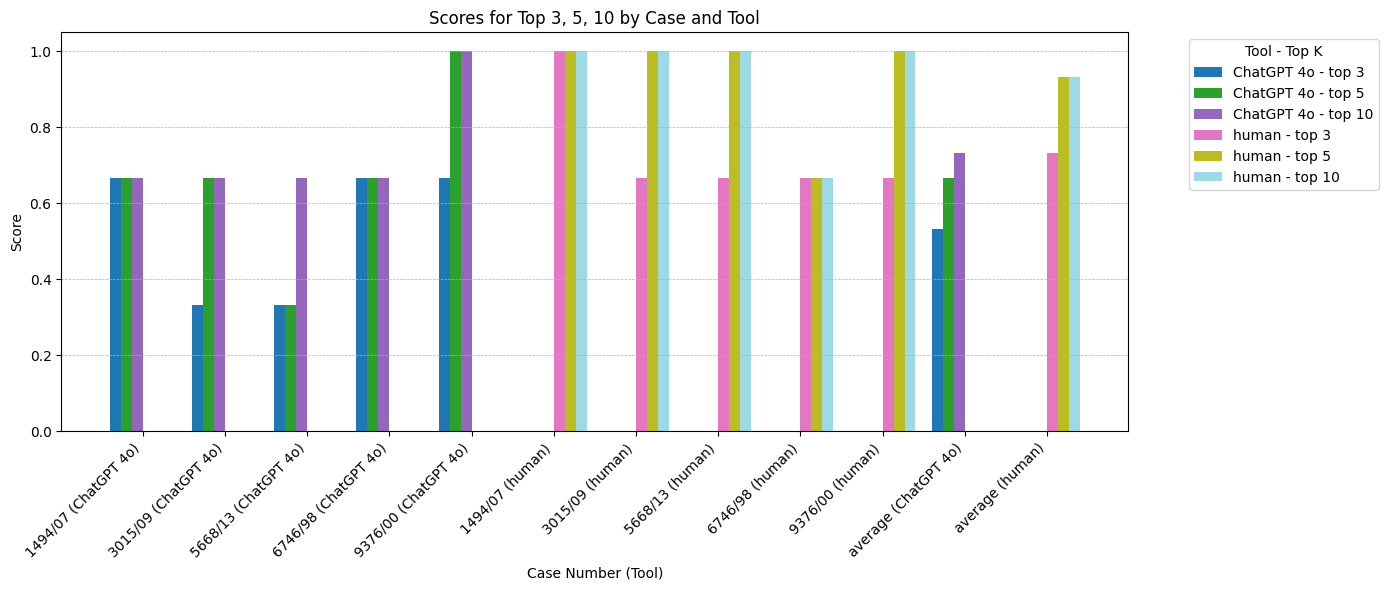

In [27]:
plot_summary_bar_chart(summarize_results_by_k(eval_res_recall_3['all_scores'], k=[3, 5, 10], aggregation='max'), summary_k=[3, 5, 10])

**Mean** scores visualization

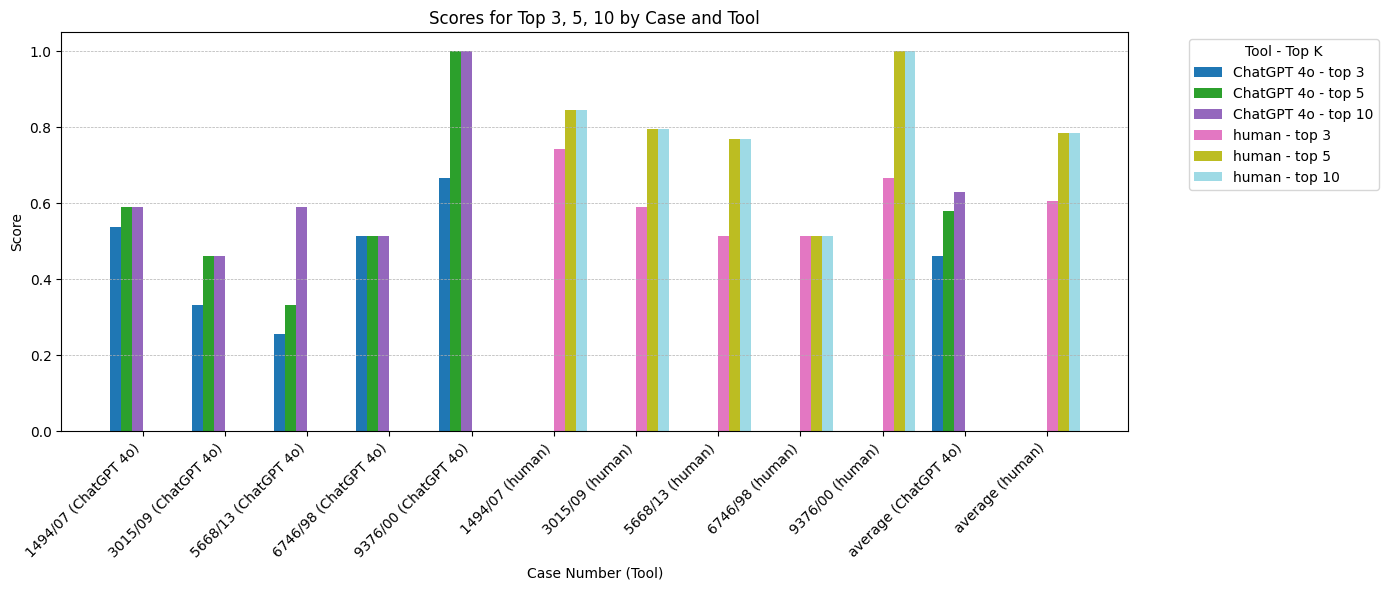

In [28]:
plot_summary_bar_chart(summarize_results_by_k(eval_res_recall_3['all_scores'], k=[3, 5, 10], aggregation='mean'), summary_k=[3, 5, 10])

**Worst** scores visualization

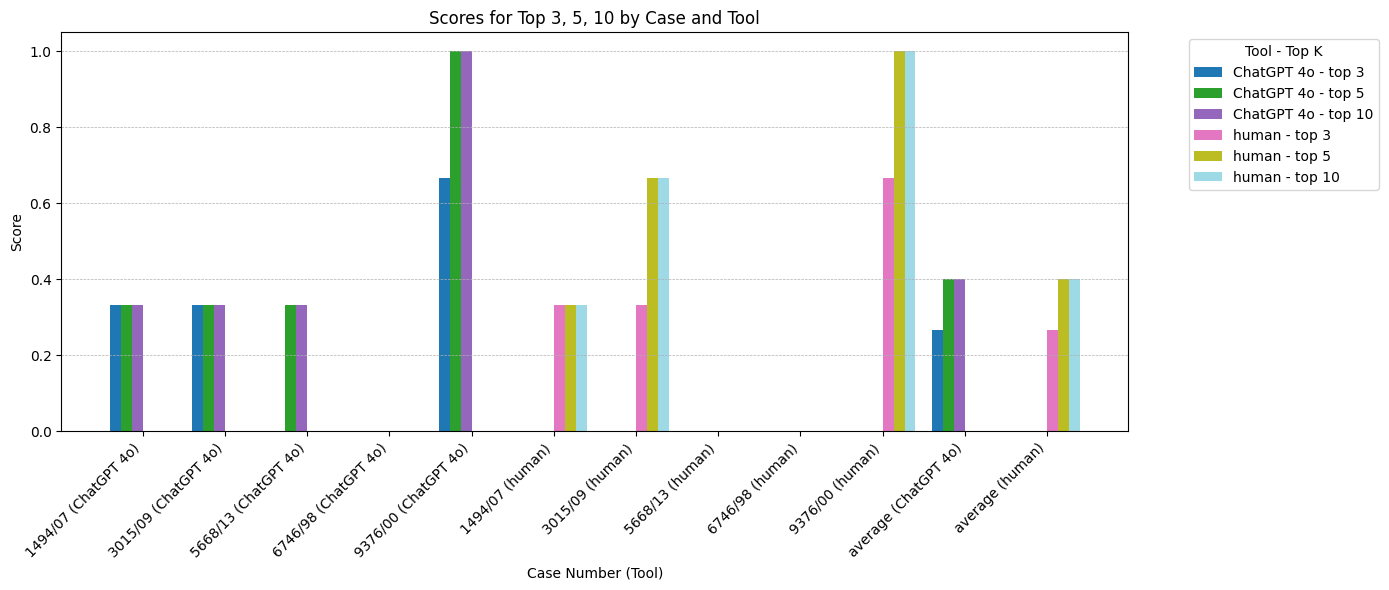

In [29]:
plot_summary_bar_chart(summarize_results_by_k(eval_res_recall_3['all_scores'], k=[3, 5, 10], aggregation='min'), summary_k=[3, 5, 10])

### Experiments and observation of hybrid search parameters impact on average score

In [30]:
r3_best_config_avg = get_best_configurations(eval_res_recall_3["all_scores"], aggregation="mean")
r3_best_config_avg

,alpha,sparse_exp,k,mean_score
11,0.3,0.01,10,0.833333
20,0.5,0.01,10,0.833333
19,0.5,0.01,5,0.800000
10,0.3,0.01,5,0.800000
26,0.5,1.0,10,0.766667
17,0.3,1.0,10,0.766667
14,0.3,0.5,10,0.766667
32,0.7,0.5,10,0.766667
29,0.7,0.01,10,0.766667
38,1.0,N/A,10,0.766667


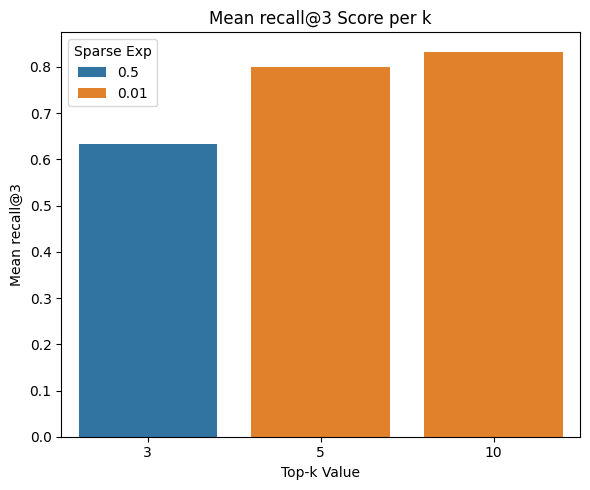

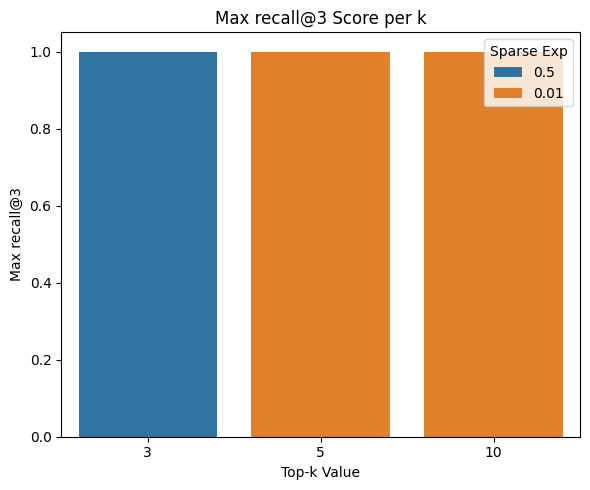

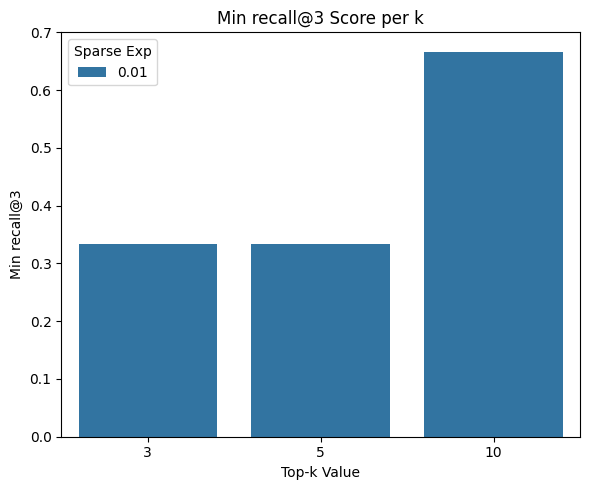

In [31]:
for v in ('mean', 'max', 'min'):
    plot_score_per_k(get_best_configurations(eval_res_recall_3["all_scores"], aggregation=v), aggregation=v, metric='recall@3')

In [32]:
for v in ('mean', 'max', 'min'):
    display(summarize_best_configurations_by_k(eval_res_recall_3['all_scores'], aggregation=v))

,alpha,sparse_exp,k,mean_score
0,0.3,0.5,3,0.633333
1,0.3,0.01,5,0.800000
2,0.3,0.01,10,0.833333


,alpha,sparse_exp,k,max_score
0,0.3,0.5,3,1.0
1,0.0,0.01,5,1.0
2,0.0,0.01,10,1.0


,alpha,sparse_exp,k,min_score
0,0.3,0.01,3,0.333333
1,0.3,0.01,5,0.333333
2,0.3,0.01,10,0.666667


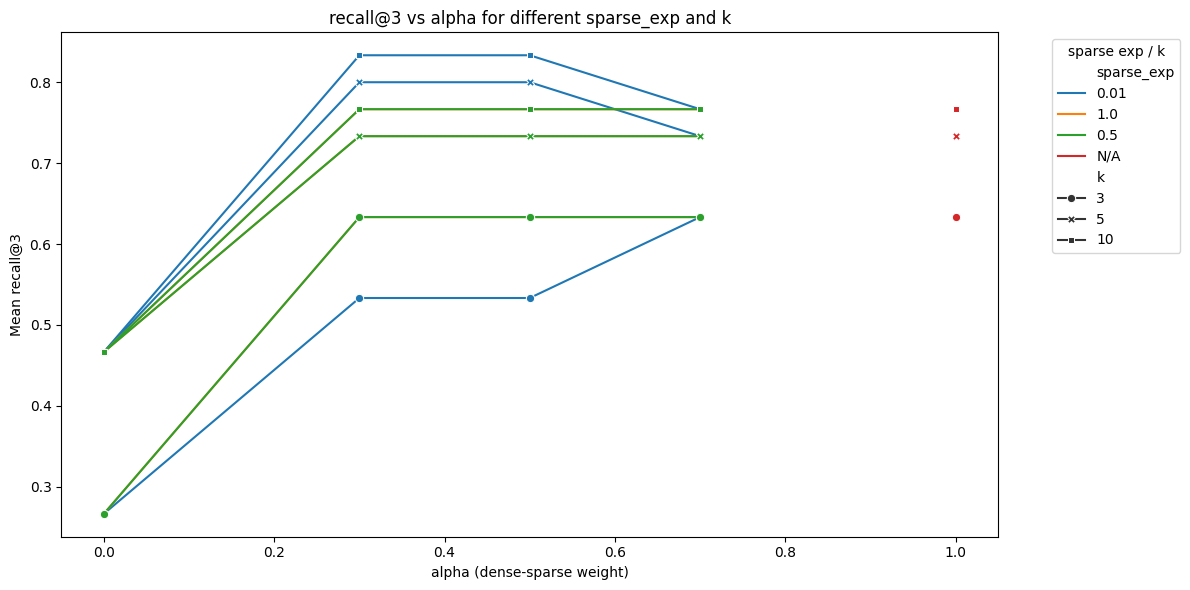

In [33]:
plot_score_vs_alpha(r3_best_config_avg, aggregation='mean', metric='recall@3')

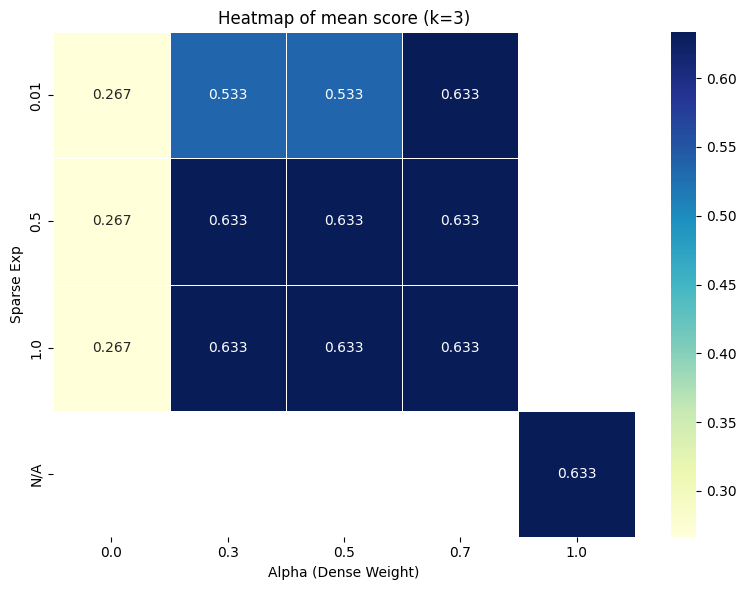

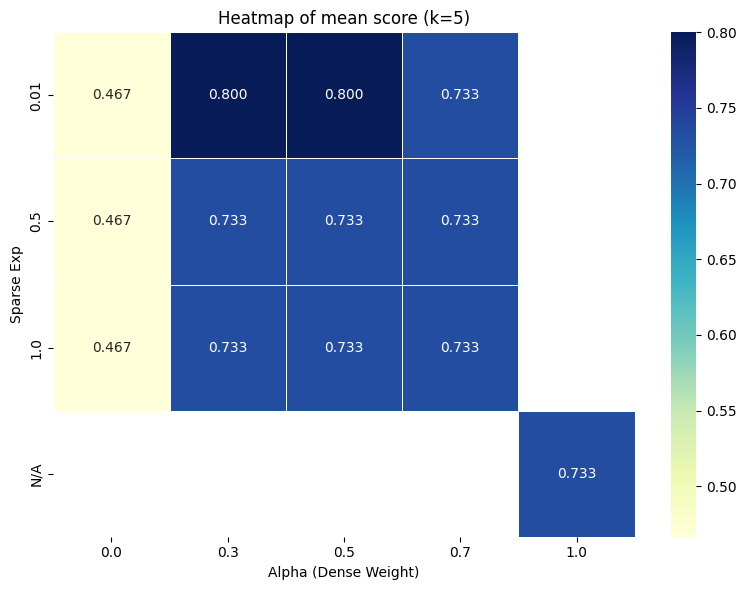

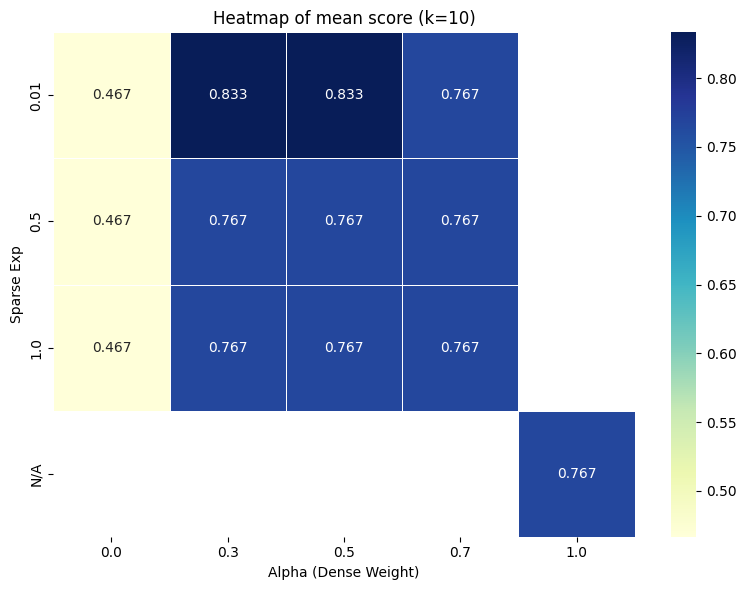

In [34]:
for k in (3, 5, 10):
    plot_alpha_sparse_heatmap(r3_best_config_avg, k=k)

<div class="alert alert-block alert-info">  
<b>⚠️ Info:</b> Based on the averge scores we can conclude that citation by it's own alpha = 0.0 can't be used in the legal case retrival. <br/>
Score values in k=3 are very low even with a high exponentiation of 0.01 (exp(number < 1, 0.1)) <br/>
On the other hand in k=5 and k=10 the sparse vector features have a positive impact when alpha=0.3 or alpha=0.5 and high gamma=0.01 (sparse scale-up), it slighlty increases the average score.
</div>

## Evaluation metric precision@k

In [35]:
eval_res_precision_k = hybrid_search_evaluation(hybrid_search_func=hybrid_search, scoring='precision@k', alpha_values=[1.0, 0.7, 0.5, 0.3, 0.0], sparse_exp_values=[1.0, 0.5, 0.01], k_values = [3, 5, 10])

In [36]:
pd.set_option('display.max_rows', eval_res_precision_k["all_scores"].shape[0])
eval_res_precision_k["all_scores"]

,case_number,tool,alpha,sparse_exp,k,score
0,1494/07,human,1.0,N/A,3,1.000000
1,1494/07,ChatGPT 4o,1.0,N/A,3,0.666667
2,9376/00,human,1.0,N/A,3,0.666667
3,9376/00,ChatGPT 4o,1.0,N/A,3,0.666667
4,5668/13,human,1.0,N/A,3,0.666667
5,5668/13,ChatGPT 4o,1.0,N/A,3,0.333333
6,3015/09,human,1.0,N/A,3,0.666667
7,3015/09,ChatGPT 4o,1.0,N/A,3,0.333333
8,6746/98,human,1.0,N/A,3,0.666667
9,6746/98,ChatGPT 4o,1.0,N/A,3,0.666667


### precision@k for top 3,5,10 - average results

In [37]:
summarize_results_by_k(eval_res_precision_k['all_scores'], k=[3, 5, 10])

,tool,case_number,top 3,top 5,top 10
0,ChatGPT 4o,1494/07,0.538462,0.353846,0.176923
1,ChatGPT 4o,3015/09,0.333333,0.276923,0.138462
2,ChatGPT 4o,5668/13,0.256410,0.200000,0.176923
3,ChatGPT 4o,6746/98,0.512821,0.307692,0.153846
4,ChatGPT 4o,9376/00,0.666667,0.600000,0.300000
5,human,1494/07,0.743590,0.507692,0.253846
6,human,3015/09,0.589744,0.476923,0.238462
7,human,5668/13,0.512821,0.461538,0.230769
8,human,6746/98,0.512821,0.307692,0.153846
9,human,9376/00,0.666667,0.600000,0.300000


### precision@k for top 3,5,10 by - best results

In [38]:
summarize_results_by_k(eval_res_precision_k['all_scores'], k=[3, 5, 10], aggregation='max')

,tool,case_number,top 3,top 5,top 10
0,ChatGPT 4o,1494/07,0.666667,0.40,0.20
1,ChatGPT 4o,3015/09,0.333333,0.40,0.20
2,ChatGPT 4o,5668/13,0.333333,0.20,0.20
3,ChatGPT 4o,6746/98,0.666667,0.40,0.20
4,ChatGPT 4o,9376/00,0.666667,0.60,0.30
5,human,1494/07,1.000000,0.60,0.30
6,human,3015/09,0.666667,0.60,0.30
7,human,5668/13,0.666667,0.60,0.30
8,human,6746/98,0.666667,0.40,0.20
9,human,9376/00,0.666667,0.60,0.30


### precision@k for top 3,5,10 - worst results

In [39]:
summarize_results_by_k(eval_res_precision_k['all_scores'], k=[3, 5, 10], aggregation='min')

,tool,case_number,top 3,top 5,top 10
0,ChatGPT 4o,1494/07,0.333333,0.20,0.10
1,ChatGPT 4o,3015/09,0.333333,0.20,0.10
2,ChatGPT 4o,5668/13,0.000000,0.20,0.10
3,ChatGPT 4o,6746/98,0.000000,0.00,0.00
4,ChatGPT 4o,9376/00,0.666667,0.60,0.30
5,human,1494/07,0.333333,0.20,0.10
6,human,3015/09,0.333333,0.40,0.20
7,human,5668/13,0.000000,0.00,0.00
8,human,6746/98,0.000000,0.00,0.00
9,human,9376/00,0.666667,0.60,0.30


### precision@k best average scores
**Note**: overall average score, cross all k, alpha and sparse exponent values

In [40]:
eval_res_precision_k['average_scores']

,case_number,tool,avg_score
0,1494/07,ChatGPT 4o,0.356410
1,1494/07,human,0.501709
2,3015/09,ChatGPT 4o,0.249573
3,3015/09,human,0.435043
4,5668/13,ChatGPT 4o,0.211111
5,5668/13,human,0.401709
6,6746/98,ChatGPT 4o,0.324786
7,6746/98,human,0.324786
8,9376/00,ChatGPT 4o,0.522222
9,9376/00,human,0.522222


### precision@k best/worst scores

In [41]:
eval_res_precision_k['best_per_case_tool']

,case_number,tool,alpha,sparse_exp,k,score
0,1494/07,ChatGPT 4o,1.0,N/A,3,0.666667
1,1494/07,human,1.0,N/A,3,1.000000
2,3015/09,ChatGPT 4o,0.5,0.01,5,0.400000
3,3015/09,human,1.0,N/A,3,0.666667
4,5668/13,ChatGPT 4o,1.0,N/A,3,0.333333
5,5668/13,human,1.0,N/A,3,0.666667
6,6746/98,ChatGPT 4o,1.0,N/A,3,0.666667
7,6746/98,human,1.0,N/A,3,0.666667
8,9376/00,ChatGPT 4o,1.0,N/A,3,0.666667
9,9376/00,human,1.0,N/A,3,0.666667


In [42]:
summarize_case_tool_scores(eval_res_precision_k["all_scores"])

,case_number,tool,avg_score,best_score,best_params,worst_score,worst_params
0,1494/07,ChatGPT 4o,0.356410,0.666667,"(1.0, N/A, 3)",0.1,"(0.0, 1.0, 10)"
1,1494/07,human,0.501709,1.000000,"(1.0, N/A, 3)",0.1,"(0.0, 1.0, 10)"
2,3015/09,ChatGPT 4o,0.249573,0.400000,"(0.5, 0.01, 5)",0.1,"(1.0, N/A, 10)"
3,3015/09,human,0.435043,0.666667,"(1.0, N/A, 3)",0.2,"(1.0, N/A, 10)"
4,5668/13,ChatGPT 4o,0.211111,0.333333,"(1.0, N/A, 3)",0.0,"(0.0, 1.0, 3)"
5,5668/13,human,0.401709,0.666667,"(1.0, N/A, 3)",0.0,"(0.0, 1.0, 3)"
6,6746/98,ChatGPT 4o,0.324786,0.666667,"(1.0, N/A, 3)",0.0,"(0.0, 1.0, 3)"
7,6746/98,human,0.324786,0.666667,"(1.0, N/A, 3)",0.0,"(0.0, 1.0, 3)"
8,9376/00,ChatGPT 4o,0.522222,0.666667,"(1.0, N/A, 3)",0.3,"(1.0, N/A, 10)"
9,9376/00,human,0.522222,0.666667,"(1.0, N/A, 3)",0.3,"(1.0, N/A, 10)"


**Best** scores visualization

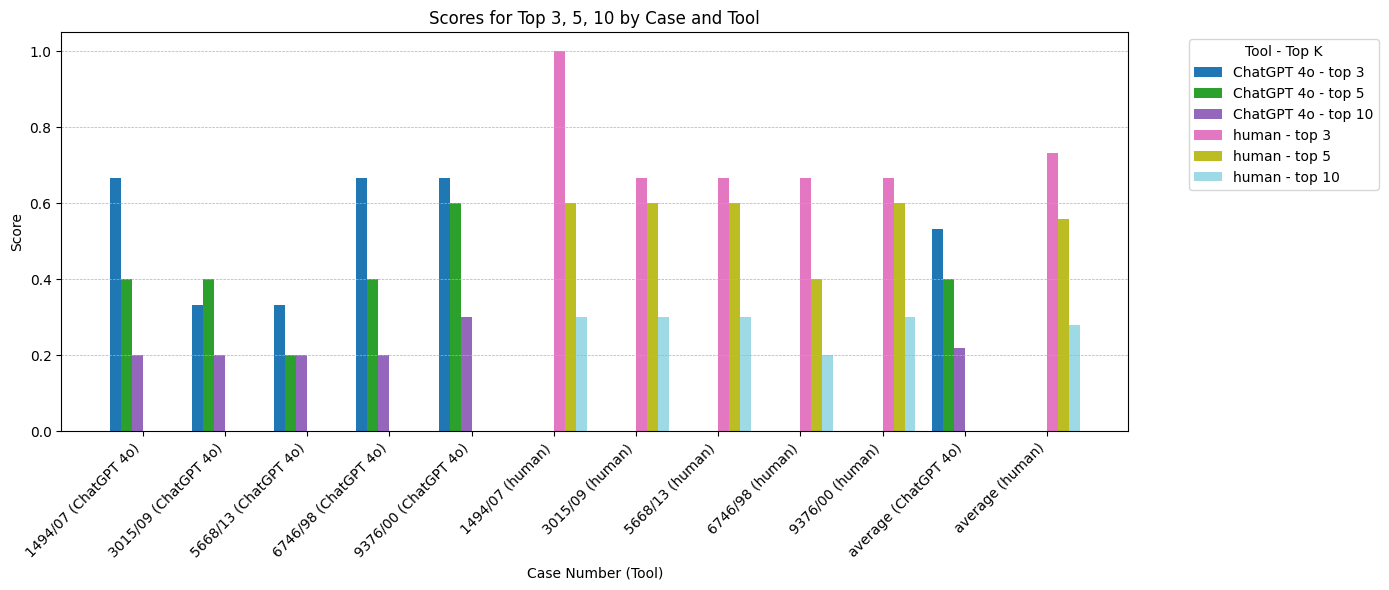

In [43]:
plot_summary_bar_chart(summarize_results_by_k(eval_res_precision_k['all_scores'], k=[3, 5, 10], aggregation='max'), summary_k=[3, 5, 10])

**Mean** scores visualization

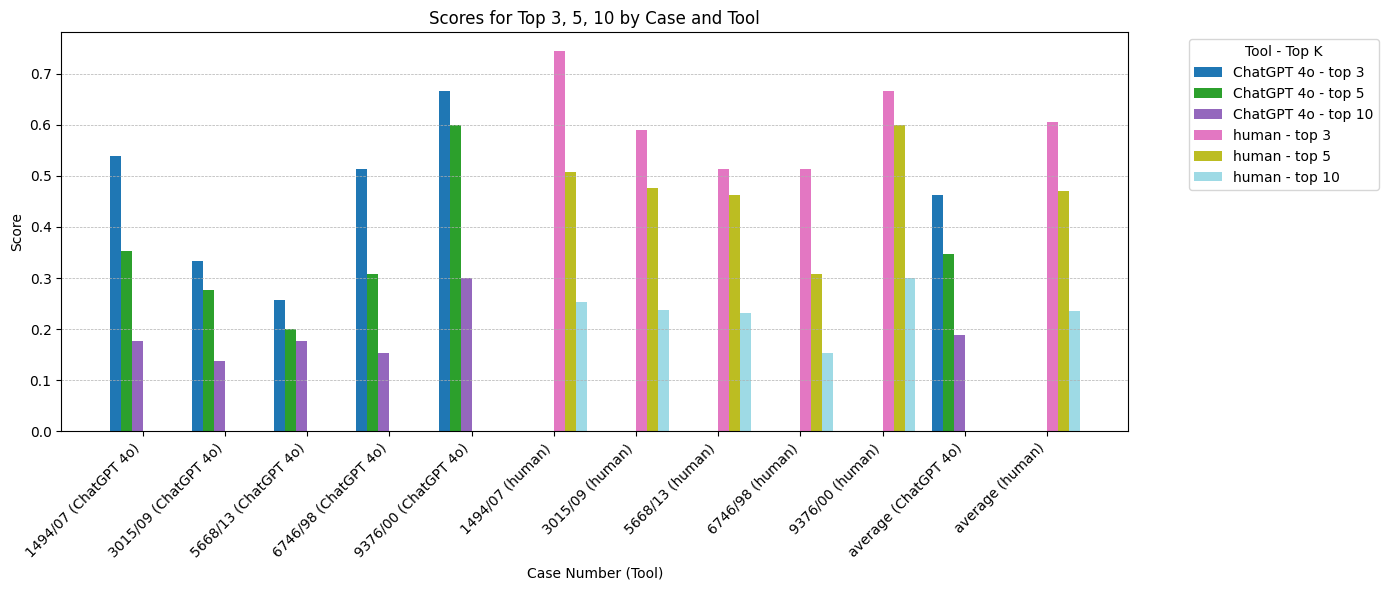

In [44]:
plot_summary_bar_chart(summarize_results_by_k(eval_res_precision_k['all_scores'], k=[3, 5, 10], aggregation='mean'), summary_k=[3, 5, 10])

**Worst** scores visualization

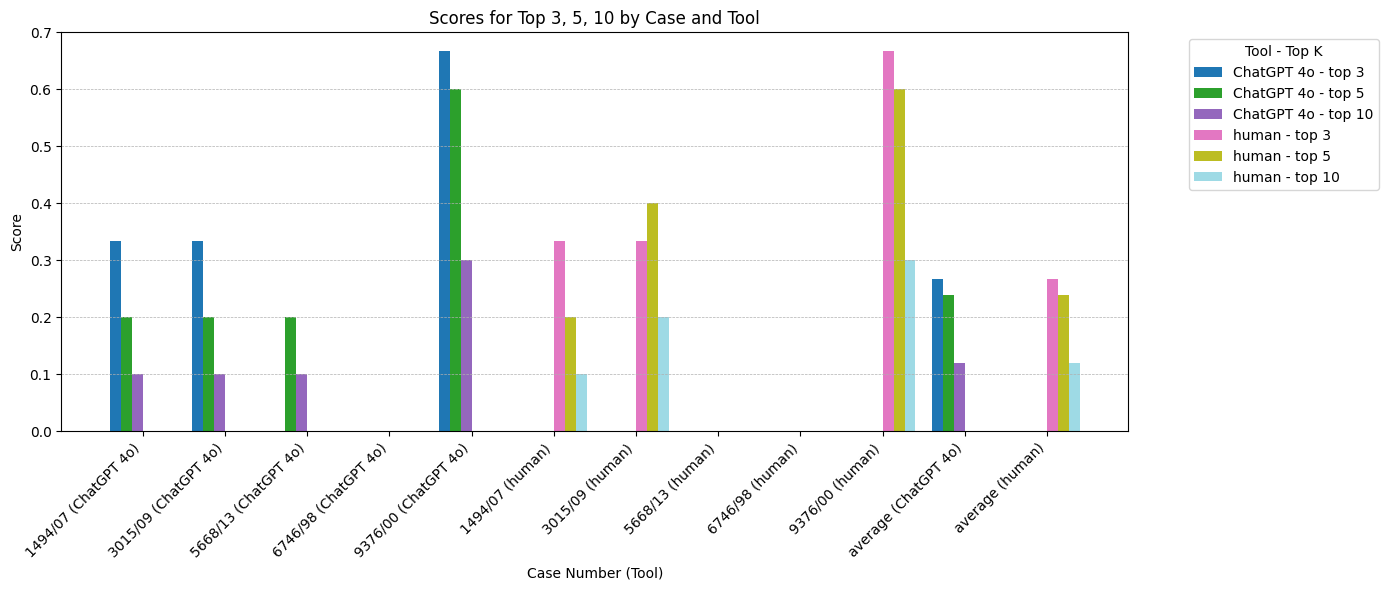

In [45]:
plot_summary_bar_chart(summarize_results_by_k(eval_res_precision_k['all_scores'], k=[3, 5, 10], aggregation='min'), summary_k=[3, 5, 10])

### Experiments and observation of hybrid search parameters impact on average score

In [46]:
pk_best_config_avg = get_best_configurations(eval_res_precision_k["all_scores"], aggregation="mean")
pk_best_config_avg

,alpha,sparse_exp,k,mean_score
27,0.7,0.01,3,0.633333
30,0.7,0.5,3,0.633333
33,0.7,1.0,3,0.633333
36,1.0,N/A,3,0.633333
21,0.5,0.5,3,0.633333
15,0.3,1.0,3,0.633333
12,0.3,0.5,3,0.633333
24,0.5,1.0,3,0.633333
18,0.5,0.01,3,0.533333
9,0.3,0.01,3,0.533333


In [47]:
for v in ['mean', 'max', 'min']:
    display(summarize_best_configurations_by_k(eval_res_precision_k['all_scores'], aggregation=v))

,alpha,sparse_exp,k,mean_score
0,0.3,0.5,3,0.633333
1,0.3,0.01,5,0.480000
2,0.3,0.01,10,0.250000


,alpha,sparse_exp,k,max_score
0,0.3,0.5,3,1.0
1,0.0,0.01,5,0.6
2,0.0,0.01,10,0.3


,alpha,sparse_exp,k,min_score
0,0.3,0.01,3,0.333333
1,0.3,0.01,5,0.200000
2,0.3,0.01,10,0.200000


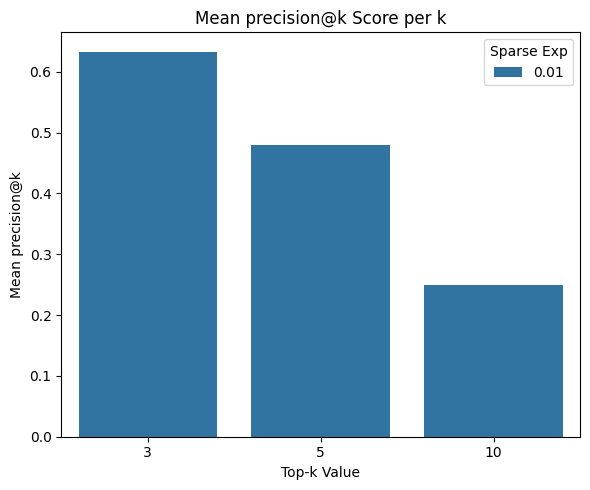

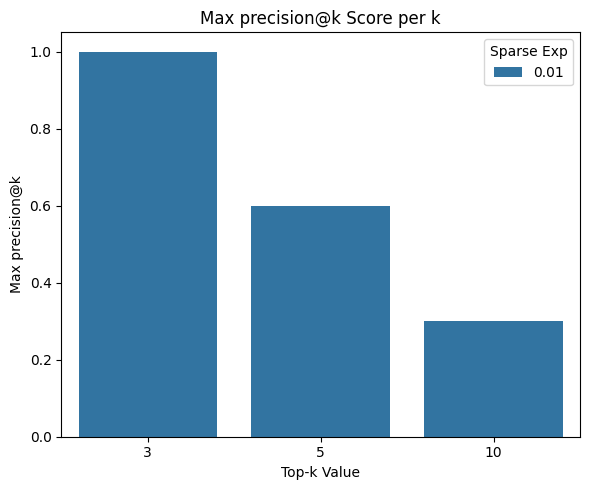

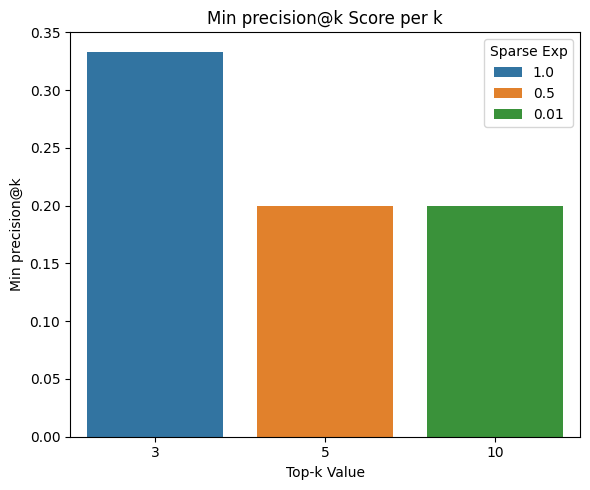

In [48]:
for v in ('mean', 'max', 'min'):
    plot_score_per_k(get_best_configurations(eval_res_precision_k['all_scores'], aggregation=v), aggregation=v, metric='precision@k')

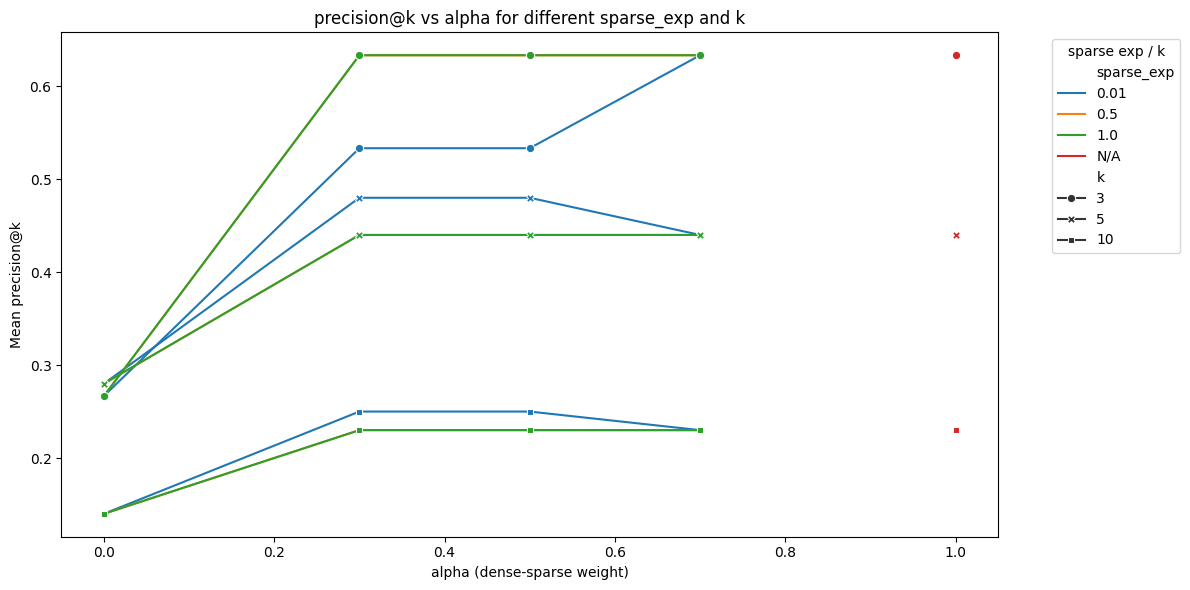

In [49]:
plot_score_vs_alpha(pk_best_config_avg, aggregation='mean', metric='precision@k')

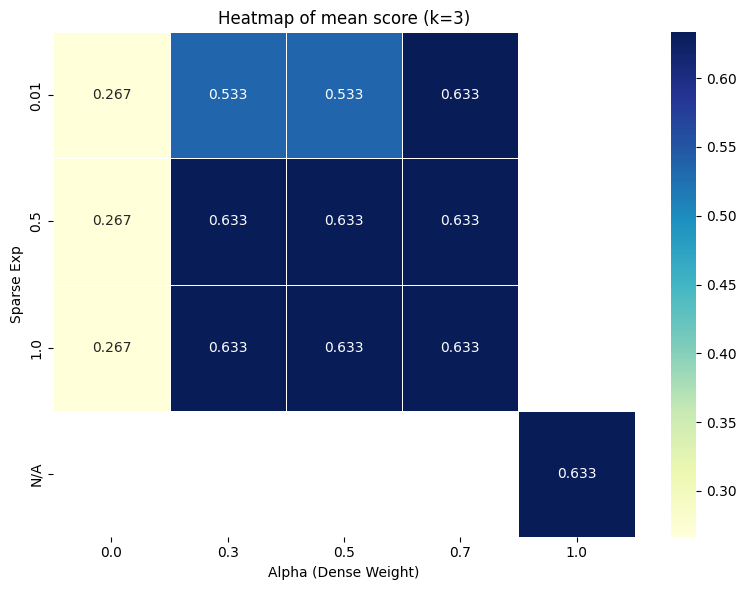

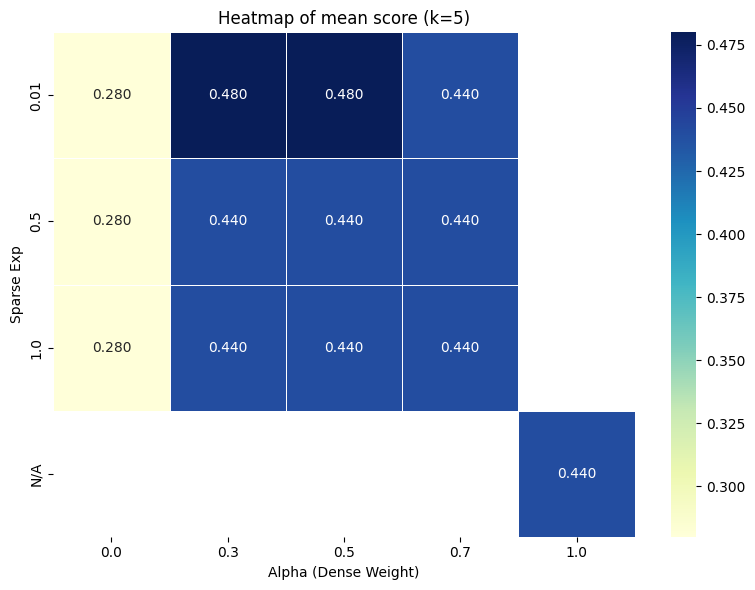

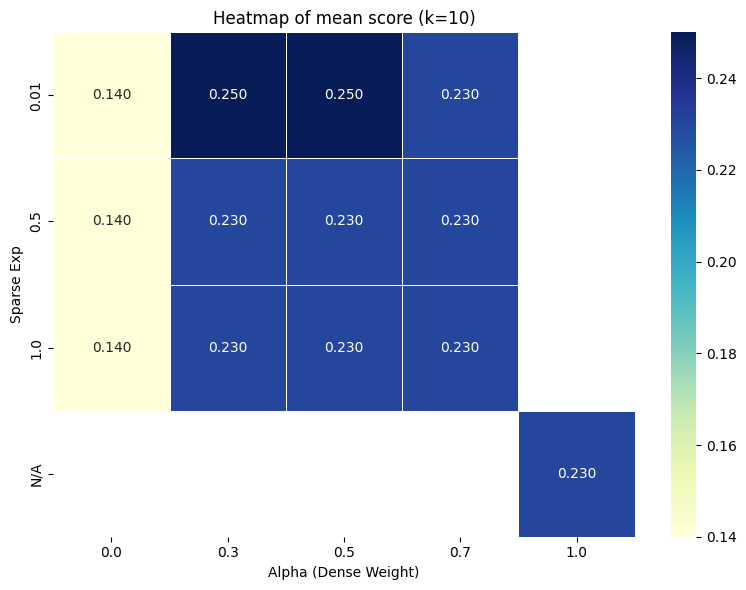

In [50]:
for k in (3, 5, 10):
    plot_alpha_sparse_heatmap(pk_best_config_avg, k=k)

<div class="alert alert-block alert-info">  
<b>⚠️ Info:</b> like in Recall average score results we observe importance of the citations only in k=5 and k=10, with α≤0.5, especially with high (low value) scale-up factor of Jaccard score (γ=0.01). <br/>
In other cases, using citation features alone led to poor performance  <br/>
</div>

In [51]:
from utils.file_utils import load_file, save_file

In [52]:
save_file(eval_res_recall_3['all_scores'], f'data/eval_res_recall_3.csv')
save_file(eval_res_precision_k['all_scores'], 'data/eval_res_precision_k.csv')

DataFrame successfully saved to data/eval_res_recall_3.csv
DataFrame successfully saved to data/eval_res_precision_k.csv
